In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
cases = ['ASD',
        'SZ',
        'BIP',
        'ADHD',
        'DEL15q11_2',
        'DEL22q11_2',
        'DUP22q11_2',
        'DEL16p11_2',
        'DUP16p11_2',
        'DEL1q21_1',
        'DUP1q21_1']

cases = ['DEL15q11_2',
        'DUP1q21_1',
        'DEL1q21_1',
        'DUP22q11_2',
        'DUP16p11_2',
        'DEL16p11_2',
        'DEL22q11_2',
        'ADHD',
        'ASD',
        'SZ',
        'BIP',]

labels = ['DEL 15q11.2',
    'DUP 1q21.1',
        'DEL 1q21.1',
        'DUP 22q11.2',
        'DUP 16p11.2',
        'DEL 16p11.2',
        'DEL 22q11.2',
        'ADHD',
        'ASD',
        'SZ',
        'BIP',]

p_single = '../results_paper/baseline/cnn/'
p_mtl = '../results_paper/mtl/cnn/'

# Load Data

In [5]:
# Single Task
st_data_conn = []
for case in cases:
    folds_conn = []
    for fold in range(5):
        # Connectomes
        p_parent = os.path.join(p_single, f"{case}/fold_{fold}")
        file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
        folds_conn.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1])[case])

    st_data_conn.append(folds_conn)

st_data_conn = dict(zip(cases,st_data_conn))

In [6]:
# Multi-task
mtl_data_conn = []
for fold in range(5):
    # Connectomes
    p_parent = os.path.join(p_mtl, f"fold_{fold}")
    file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
    mtl_data_conn.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1]))


# Get Accuracy

In [7]:
# Single Task
st_acc_conn = []
st_acc_conn_std = []
for case in cases:
    # Connectomes
    vals = [st_data_conn[case][fold]['Accuracy/test'].iloc[-1] for fold in range(5)]
    st_acc_conn.append(np.mean(vals))
    st_acc_conn_std.append(np.std(vals))


st_acc_conn = pd.Series(st_acc_conn,index=cases)
st_acc_conn_std = pd.Series(st_acc_conn_std,index=cases)

In [8]:
# Multi-task
mtl_acc_conn = []
for fold in range(5):
    # Connectomes
    df = mtl_data_conn[fold].transpose().reset_index()
    df = df[df['level_1']=='Accuracy/test'].set_index('level_0')[99]
    mtl_acc_conn.append(df)
    
mtl_acc_conn_std = pd.concat(mtl_acc_conn,axis=1).std(axis=1)
mtl_acc_conn = pd.concat(mtl_acc_conn,axis=1).mean(axis=1)

# Tables

In [9]:
# Connectomes
df_conn = pd.concat([st_acc_conn,mtl_acc_conn,st_acc_conn_std,mtl_acc_conn_std],axis=1)
df_conn.columns = ['ST','MTL','ST_std','MTL_std']
df_conn

,ST,MTL,ST_std,MTL_std
DEL15q11_2,57.781649,60.673635,4.351605,5.597612
DUP1q21_1,63.571429,55.357143,17.663233,24.353896
DEL1q21_1,66.000000,58.000000,16.248077,17.888544
DUP22q11_2,48.333333,55.000000,17.177361,12.484558
DUP16p11_2,71.428571,65.714286,7.824608,13.739560
DEL16p11_2,76.538462,75.128205,8.461538,12.416718
DEL22q11_2,86.078431,78.039216,12.061613,10.775397
ADHD,55.029985,61.103448,2.105291,4.961200
ASD,60.873016,59.175954,1.983670,4.594763
SZ,78.069636,72.411417,3.667903,0.943594


In [10]:
df_conn.mean()

ST         67.638827
MTL        65.414083
ST_std      8.758712
MTL_std    10.142012
dtype: float64

# Plots

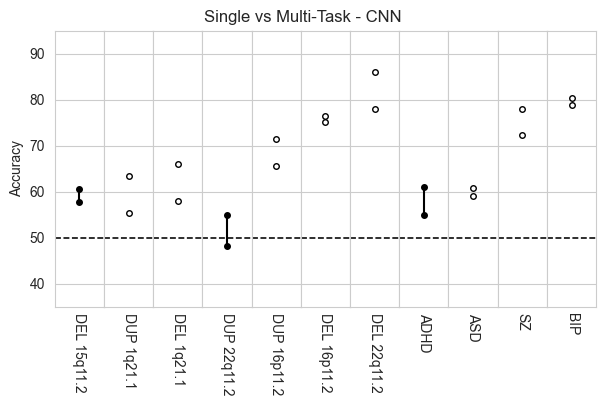

In [13]:
###############
# CONNECTOMES #
###############
title = 'Single vs Multi-Task - CNN'
fig,ax = plt.subplots(1,len(cases),figsize=(6,4),sharey=True,sharex=True)
plt.yticks([40,50,60,70,80,90])
sns.set_style('whitegrid')
colors = ['black','darkorchid','red','orange','dodgerblue','forestgreen']

for j,case in enumerate(cases):
    st_acc = df_conn.loc[case]['ST']
    mtl_acc = df_conn.loc[case]['MTL']
    if st_acc > mtl_acc:
        mfc = 'white'
        ls =''
    else:
        mfc = colors[0]
        ls = '-'

    ax[j].plot(5,mtl_acc,marker='o',color=colors[0],ms=4,markerfacecolor=mfc)
    ax[j].plot(5,st_acc,marker='o',color=colors[0],ms=4,markerfacecolor=mfc)
    ax[j].plot((5,5),(st_acc,mtl_acc),color=colors[0],ls=ls)
    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    ax[j].set_xlabel(labels[j],rotation=270)

    lines = ax[j].get_ygridlines()
    b = lines[1]
    b.set_color('black')
    b.set_linewidth(1.15)
    b.set_linestyle('--')

ax[0].set_ylabel('Accuracy')
plt.suptitle(title)
plt.ylim(35,95)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0)
plt.savefig(os.path.join('/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results_paper/mtl/','figures/st_vs_mtl_cnn.png'),dpi=300)